# Deep Learning Network for Text Document Classification

## Lab Experiment: Design and Implementation

**Course:** Deep Learning and Reinforcement Learning (BAI701)  
**Experiment:** Design and implement a deep learning network for classification of textual documents

---

### Learning Objectives:
- Understand text preprocessing techniques for deep learning
- Implement various neural network architectures for text classification
- Compare different approaches: Dense, CNN, LSTM, and Transformer-based models
- Evaluate model performance and understand hyperparameter tuning

### Prerequisites:
- Basic understanding of neural networks
- Familiarity with Python and TensorFlow/Keras
- Knowledge of text processing concepts

## 1. Environment Setup and Imports

In [ ]:
# Install required packages (run this if packages are not already installed)
# !pip install tensorflow scikit-learn matplotlib seaborn wordcloud nltk

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Dense, Embedding, LSTM, Conv1D, MaxPooling1D, GlobalMaxPooling1D,
    Dropout, BatchNormalization, Input, Concatenate, Flatten
)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.datasets import fetch_20newsgroups

# Text processing
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

# Download NLTK data
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("Environment setup complete!")
print(f"TensorFlow version: {tf.__version__}")

Environment setup complete!
TensorFlow version: 2.17.0


## 2. Data Loading and Exploration

We'll use the 20 Newsgroups dataset, which contains documents from 20 different newsgroup categories.

In [3]:
# Load the 20 newsgroups dataset
# We'll use a subset for faster training in this lab
categories = ['alt.atheism', 'soc.religion.christian', 'comp.graphics', 'sci.med', 'talk.politics.misc']  # Define the categories to use

print("Loading dataset...")  # Print status message

# fetch_20newsgroups is a function from sklearn.datasets that loads the 20 Newsgroups text dataset
newsgroups_train = fetch_20newsgroups(
    subset='train',  # Use the training split
    categories=categories,  # Restrict to selected categories
    shuffle=True,  # Shuffle the data
    random_state=42,  # Set random seed for reproducibility
    remove=('headers', 'footers', 'quotes')  # Remove metadata for cleaner text
)

# Load test data
newsgroups_test = fetch_20newsgroups(
    subset='test',  # Use the test split
    categories=categories,  # Restrict to selected categories
    shuffle=True,  # Shuffle the data
    random_state=42,  # Set random seed for reproducibility
    remove=('headers', 'footers', 'quotes')  # Remove metadata for cleaner text
)

print(f"Training samples: {len(newsgroups_train.data)}")  # Print number of training samples
print(f"Test samples: {len(newsgroups_test.data)}")  # Print number of test samples
print(f"Categories: {newsgroups_train.target_names}")  # Print the list of categories

Loading dataset...
Training samples: 2722
Test samples: 1812
Categories: ['alt.atheism', 'comp.graphics', 'sci.med', 'soc.religion.christian', 'talk.politics.misc']


In [4]:
# Create DataFrame for easier handling
train_df = pd.DataFrame({
    'text': newsgroups_train.data,
    'category': [newsgroups_train.target_names[i] for i in newsgroups_train.target],
    'target': newsgroups_train.target
})

test_df = pd.DataFrame({
    'text': newsgroups_test.data,
    'category': [newsgroups_test.target_names[i] for i in newsgroups_test.target],
    'target': newsgroups_test.target
})

print("Dataset Structure:")
print(train_df.head())
print(f"\nClass distribution in training set:")
print(train_df['category'].value_counts())

Dataset Structure:
                                                text                category  \
0  \nSince the actual verdicts were not known by ...      talk.politics.misc   
1  Sorry I missed you Raymond, I was just out in ...           comp.graphics   
2  \n[a lot of stuff deleted]\n\n:      For that ...  soc.religion.christian   
3  \n Well, yes.  That was a part of my point.  A...                 sci.med   
4  \nI guess your strength isn't in math. Clinton...      talk.politics.misc   

   target  
0       4  
1       1  
2       3  
3       2  
4       4  

Class distribution in training set:
category
soc.religion.christian    599
sci.med                   594
comp.graphics             584
alt.atheism               480
talk.politics.misc        465
Name: count, dtype: int64


In [5]:
# Explore the data
print("Sample document:")
print("Category:", train_df.iloc[0]['category'])
print("Text (first 500 characters):")
print(train_df.iloc[0]['text'][:500])
print("...")

Sample document:
Category: talk.politics.misc
Text (first 500 characters):

Since the actual verdicts were not known by the authorities, it was
smart not to allow "Friday night for fighting" (sorry, Elton) and to
seal them for this morning.  Also, it allows for maximum daylight to
wear down and frustrate any potential troublemakers, as well as give
more preparation time.


Are you a local news intern? (-;


Actually, that was 8 PM 'cos it was shown live on our 11 PM news
and cut into CNN's 11 O'clock Sports (sorry, but I didn't watch
the Devils-Islanders game!  No Spor
...


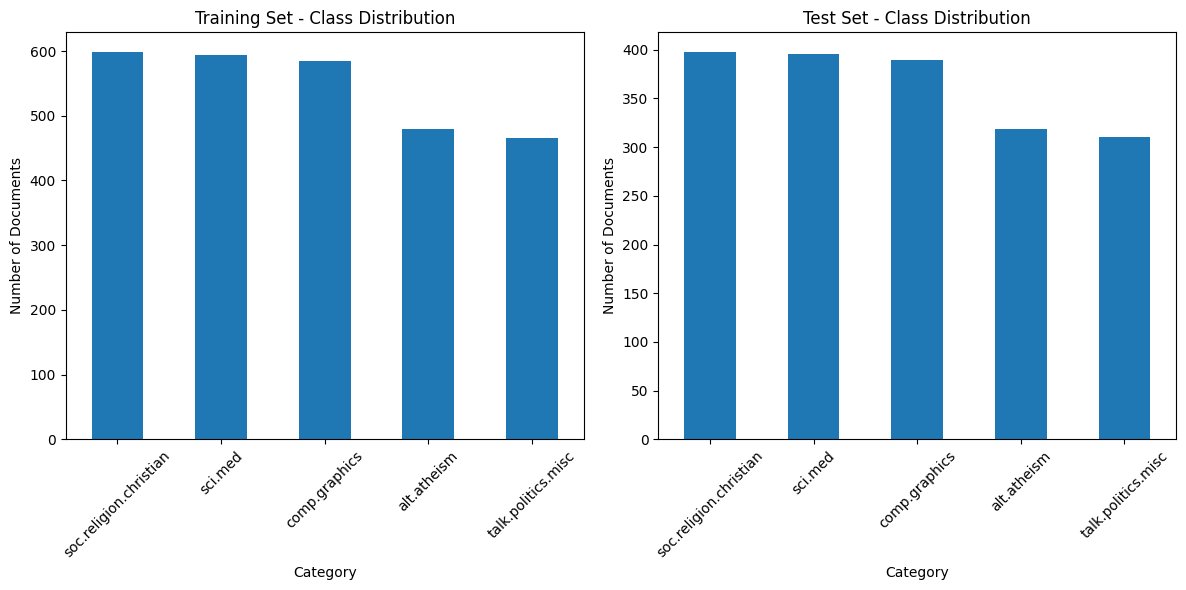

In [6]:
# Visualize class distribution
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
train_df['category'].value_counts().plot(kind='bar')
plt.title('Training Set - Class Distribution')
plt.xlabel('Category')
plt.ylabel('Number of Documents')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
test_df['category'].value_counts().plot(kind='bar')
plt.title('Test Set - Class Distribution')
plt.xlabel('Category')
plt.ylabel('Number of Documents')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## 3. Text Preprocessing

Text preprocessing is crucial for deep learning models. We'll implement several preprocessing steps.

In [16]:
!pip install spacy
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 3.7 MB/s  0:00:03 eta 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [19]:
import spacy

# 'punkt_tab' is not a valid NLTK resource; for tokenization, 'punkt' is required and already downloaded in previous cells.
# No additional download needed here.

# Initialize preprocessing tools
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))
# Tokenize
# Use spaCy for tokenization
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

def preprocess_text(text, remove_stopwords=True, apply_stemming=True):
    """
    Preprocess text data:
    - Convert to lowercase
    - Remove special characters and digits
    - Remove extra whitespace
    - Tokenize
    - Remove stopwords (optional)
    - Apply stemming (optional)
    """
    # Convert to lowercase
    text = text.lower()
    
    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Remove extra whitespace
    text = ' '.join(text.split())
    

    tokens = [token.text for token in nlp(text)]
    
    # Remove stopwords
    if remove_stopwords:
        tokens = [token for token in tokens if token not in stop_words]
    
    # Apply stemming
    if apply_stemming:
        tokens = [stemmer.stem(token) for token in tokens]
    
    return ' '.join(tokens)

# Test the preprocessing function
sample_text = train_df.iloc[0]['text'][:200]
print("Original text:")
print(sample_text)
print("\nPreprocessed text:")
print(preprocess_text(sample_text))

Original text:

Since the actual verdicts were not known by the authorities, it was
smart not to allow "Friday night for fighting" (sorry, Elton) and to
seal them for this morning.  Also, it allows for maximum dayli

Preprocessed text:
sinc actual verdict known author smart allow friday night fight sorri elton seal morn also allow maximum dayli


In [22]:
# Reduce the number of documents: keep only top 100 per category in both train and test sets

def reduce_to_top_n_per_category(df, n=50):
    return df.groupby('category').head(n).reset_index(drop=True)

train_df = reduce_to_top_n_per_category(train_df, n=50)
test_df = reduce_to_top_n_per_category(test_df, n=50)

print("Reduced training set size:", len(train_df))
print("Reduced test set size:", len(test_df))
print("Training set class distribution:\n", train_df['category'].value_counts())
print("Test set class distribution:\n", test_df['category'].value_counts())

Reduced training set size: 250
Reduced test set size: 250
Training set class distribution:
 category
talk.politics.misc        50
comp.graphics             50
soc.religion.christian    50
sci.med                   50
alt.atheism               50
Name: count, dtype: int64
Test set class distribution:
 category
comp.graphics             50
soc.religion.christian    50
sci.med                   50
talk.politics.misc        50
alt.atheism               50
Name: count, dtype: int64


In [23]:
# Apply preprocessing to the entire dataset
print("Preprocessing training data...")
train_df['processed_text'] = train_df['text'].apply(preprocess_text)

print("Preprocessing test data...")
test_df['processed_text'] = test_df['text'].apply(preprocess_text)

# Remove empty documents after preprocessing
train_df = train_df[train_df['processed_text'].str.len() > 0]
test_df = test_df[test_df['processed_text'].str.len() > 0]

print(f"Training samples after preprocessing: {len(train_df)}")
print(f"Test samples after preprocessing: {len(test_df)}")

Preprocessing training data...
Preprocessing test data...
Training samples after preprocessing: 245
Test samples after preprocessing: 243


/var/folders/l4/f7ythdmn3cxcjm_wvnpqx54r0000gn/T/ipykernel_47769/2267329165.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([train_lengths, test_lengths], labels=['Train', 'Test'])


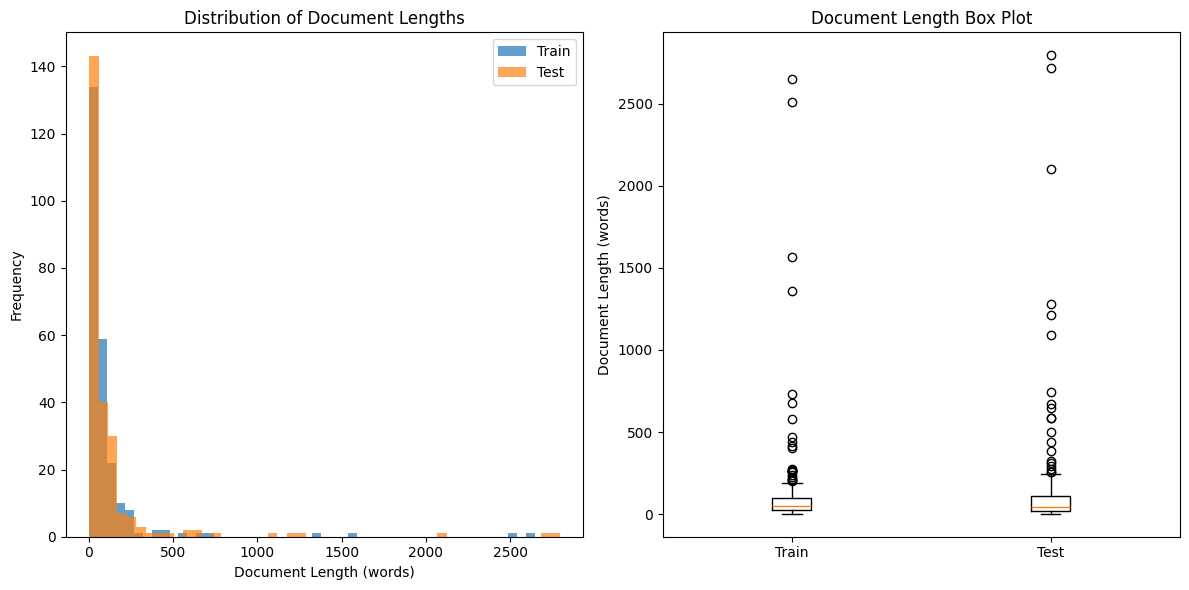

Average training document length: 111.5 words
Average test document length: 124.1 words
95th percentile length: 266 words


In [24]:
# Analyze text lengths
train_lengths = train_df['processed_text'].str.split().str.len()
test_lengths = test_df['processed_text'].str.split().str.len()

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(train_lengths, bins=50, alpha=0.7, label='Train')
plt.hist(test_lengths, bins=50, alpha=0.7, label='Test')
plt.xlabel('Document Length (words)')
plt.ylabel('Frequency')
plt.title('Distribution of Document Lengths')
plt.legend()

plt.subplot(1, 2, 2)
plt.boxplot([train_lengths, test_lengths], labels=['Train', 'Test'])
plt.ylabel('Document Length (words)')
plt.title('Document Length Box Plot')

plt.tight_layout()
plt.show()

print(f"Average training document length: {train_lengths.mean():.1f} words")
print(f"Average test document length: {test_lengths.mean():.1f} words")
print(f"95th percentile length: {np.percentile(train_lengths, 95):.0f} words")

## 4. Text Tokenization and Sequence Preparation

In [28]:
# Set parameters for tokenization
MAX_VOCAB_SIZE = 10000  # Maximum vocabulary size
MAX_SEQUENCE_LENGTH = 200  # Maximum sequence length (based on 95th percentile)
EMBEDDING_DIM = 100  # Embedding dimension

# Initialize tokenizer
# Tokenizer is from tensorflow.keras.preprocessing.text
tokenizer = Tokenizer(
    num_words=MAX_VOCAB_SIZE,
    oov_token='<OOV>',  # Out-of-vocabulary token
    lower=True
)

# Fit tokenizer on training data
print("Fitting tokenizer...")  # Print status message
tokenizer.fit_on_texts(train_df['processed_text'])  # Learn the vocabulary from the training data

# Example: The tokenizer "learns" the words e.g.: 'deep', 'learning', 'i', 'love', 'is', 'fun'
# Output: {'deep': 1, 'learning': 2, 'i': 3, 'love': 4, 'is': 5, 'fun': 6}


# Convert texts to sequences
# This means: each word in the text is replaced by its integer index from the tokenizer's vocabulary.
# Example:
# If tokenizer.word_index = {'i': 1, 'love': 2, 'deep': 3, 'learning': 4}
# Then, tokenizer.texts_to_sequences(['I love deep learning']) will output: [[1, 2, 3, 4]]
print("Converting texts to sequences...")
X_train_seq = tokenizer.texts_to_sequences(train_df['processed_text'])
X_test_seq = tokenizer.texts_to_sequences(test_df['processed_text'])

# Pad sequences to ensure uniform length
# Padding is required because deep learning models expect input sequences to have the same length.
# Text documents naturally have variable lengths, but neural networks (especially in batch processing)
# require fixed-size input tensors. Padding ensures all sequences are of uniform length by adding zeros
# (or another value) to the end (or beginning) of shorter sequences.

# Example:
# Suppose MAX_SEQUENCE_LENGTH = 6
# Original sequences:
#   [12, 45, 78]
#   [4, 5, 6, 7, 8]
# After padding (post):
#   [12, 45, 78, 0, 0, 0]
#   [4, 5, 6, 7, 8, 0]
print("Padding sequences...")
X_train_padded = pad_sequences(X_train_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

print(f"Vocabulary size: {len(tokenizer.word_index)}")
print(f"Training sequences shape: {X_train_padded.shape}")
print(f"Test sequences shape: {X_test_padded.shape}")

Fitting tokenizer...
Converting texts to sequences...
Padding sequences...
Vocabulary size: 5533
Training sequences shape: (245, 200)
Test sequences shape: (243, 200)


In [29]:
# Prepare labels
# The 'target' column contains integer-encoded class labels for each document.
# Each integer corresponds to a category in the 'categories' list:
# 0: alt.atheism
# 1: soc.religion.christian
# 2: comp.graphics
# 3: sci.med
# 4: talk.politics.misc
# These are then converted to one-hot encoded vectors for model training.
y_train = train_df['target'].values
y_test = test_df['target'].values

# Convert to categorical (one-hot encoding)
# Deep learning models (especially with 'categorical_crossentropy' loss) expect the labels to be in one-hot encoded format.
# One-hot encoding transforms each class label (e.g., 0, 1, 2, ...) into a binary vector where only the index of the class is 1 and the rest are 0.
# For example, for 5 classes: label 2 becomes [0, 0, 1, 0, 0].
# This format is required for multi-class classification so the model can output a probability distribution over all classes.
num_classes = len(categories)
y_train_cat = to_categorical(y_train, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

print(f"Number of classes: {num_classes}")
print(f"Training labels shape: {y_train_cat.shape}")
print(f"Test labels shape: {y_test_cat.shape}")

Number of classes: 5
Training labels shape: (245, 5)
Test labels shape: (243, 5)


In [30]:
# Create validation split from training data
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train_padded, y_train_cat, 
    test_size=0.2, 
    stratify=y_train, 
    random_state=42
)

print(f"Final training set: {X_train_final.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test_padded.shape}")

Final training set: (196, 200)
Validation set: (49, 200)
Test set: (243, 200)


## 5. Model Architectures

We'll implement and compare different deep learning architectures for text classification.

### 5.1 Simple Dense Neural Network

In [37]:
def create_dense_model(vocab_size, embedding_dim, max_length, num_classes):
    """
    Create a simple dense neural network with embedding layer
    """
    # This function creates a simple dense neural network for text classification.
    # It uses an Embedding layer to learn word representations, flattens the output,
    # and then applies two dense layers with dropout for regularization before the final classification layer.
    model = Sequential([
        # Embedding layer: maps each word index to a dense vector of fixed size
        # vocab_size: size of the vocabulary (number of unique tokens to consider)
        # embedding_dim: dimension of the dense embedding vectors
        # input_length: length of input sequences (number of tokens per document)
        Embedding(vocab_size, embedding_dim, input_length=max_length),

        # Flatten layer: converts the 2D embedding output into a 1D vector for the dense layers
        Flatten(),

        # First dense (fully connected) layer with ReLU activation
        # 128 units: number of neurons in this layer
        Dense(128, activation='relu'),

        # Dropout layer: randomly sets input units to 0 with a frequency of 0.5 during training
        # Helps prevent overfitting
        Dropout(0.5),

        # Second dense layer with ReLU activation
        # 64 units: number of neurons in this layer
        Dense(64, activation='relu'),

        # Dropout layer: further regularization
        Dropout(0.5),

        # Output layer: softmax activation for multi-class classification
        # num_classes: number of output classes
        Dense(num_classes, activation='softmax')
    ])
    
    return model

# Create and compile the dense model
dense_model = create_dense_model(MAX_VOCAB_SIZE, EMBEDDING_DIM, MAX_SEQUENCE_LENGTH, num_classes)

dense_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Compiling the model configures it for training:
# - 'optimizer' (e.g., 'adam') determines how the model weights are updated based on the loss function.
# - 'loss' (e.g., 'categorical_crossentropy') measures how well the model's predictions match the true labels.
# - 'metrics' (e.g., 'accuracy') are used to evaluate the model's performance during training and testing.
# This step prepares the model to be trained with data using .fit().

print("Dense Model Architecture:")
dense_model.summary()

Dense Model Architecture:


/Users/pruthvirajv/Library/CloudStorage/OneDrive-ArivuAIInnovationsPrivateLimited(2)/Oil & Gas/GSSS-DeepLearning-Course/module1_dl_env/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

This is a summary of a Keras Sequential model, but the model is "unbuilt" because it hasn't seen input data yet (or `build()`/`fit()` hasn't been called). Here’s what each column means:

- **Layer (type):** The name and type of each layer in your model (e.g., Embedding, Flatten, Dense, Dropout).
- **Output Shape:** The shape of the output tensor from each layer. Here, it shows `?` because the model is not built yet (input shape is unknown).
- **Param #:** The number of trainable parameters in each layer. It shows `0 (unbuilt)` for most layers because the model hasn't been built.

**Why "unbuilt"?**
- The model needs to know the input shape (e.g., after calling `fit()` or `build()`), then it can compute output shapes and parameter counts.

**How to fix?**
- Call `model.build(input_shape=(None, MAX_SEQUENCE_LENGTH))` or run `model.summary()` after fitting or building the model.

**Summary:**  
This table lists your model’s layers, but the details are missing because the model hasn’t been built with input data yet. Once built, it will show output shapes and parameter counts for each layer.

### 5.2 Convolutional Neural Network (CNN)

In [36]:
def create_cnn_model(vocab_size, embedding_dim, max_length, num_classes):
    """
    Create a CNN model for text classification
    """
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=max_length),
        
        # First convolutional block
        Conv1D(filters=128, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        
        # Second convolutional block
        Conv1D(filters=128, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        
        # Third convolutional block
        Conv1D(filters=128, kernel_size=3, activation='relu'),
        GlobalMaxPooling1D(),
        
        # Dense layers
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    
    return model

# Create and compile the CNN model
cnn_model = create_cnn_model(MAX_VOCAB_SIZE, EMBEDDING_DIM, MAX_SEQUENCE_LENGTH, num_classes)

cnn_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("CNN Model Architecture:")
cnn_model.summary()

CNN Model Architecture:


/Users/pruthvirajv/Library/CloudStorage/OneDrive-ArivuAIInnovationsPrivateLimited(2)/Oil & Gas/GSSS-DeepLearning-Course/module1_dl_env/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

### 5.3 Long Short-Term Memory (LSTM) Network

In [38]:
def create_lstm_model(vocab_size, embedding_dim, max_length, num_classes):
    """
    Create an LSTM model for text classification
    """
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=max_length),
        
        # LSTM layers
        LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2),
        LSTM(64, dropout=0.2, recurrent_dropout=0.2),
        
        # Dense layers
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    
    return model

# Create and compile the LSTM model
lstm_model = create_lstm_model(MAX_VOCAB_SIZE, EMBEDDING_DIM, MAX_SEQUENCE_LENGTH, num_classes)

lstm_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("LSTM Model Architecture:")
lstm_model.summary()

LSTM Model Architecture:


/Users/pruthvirajv/Library/CloudStorage/OneDrive-ArivuAIInnovationsPrivateLimited(2)/Oil & Gas/GSSS-DeepLearning-Course/module1_dl_env/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

### 5.4 Hybrid CNN-LSTM Model

In [39]:
def create_cnn_lstm_model(vocab_size, embedding_dim, max_length, num_classes):
    """
    Create a hybrid CNN-LSTM model for text classification
    """
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=max_length),
        
        # CNN layers for feature extraction
        Conv1D(filters=64, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        
        # LSTM layers for sequence modeling
        LSTM(64, return_sequences=True, dropout=0.2),
        LSTM(32, dropout=0.2),
        
        # Dense layers
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    
    return model

# Create and compile the CNN-LSTM model
cnn_lstm_model = create_cnn_lstm_model(MAX_VOCAB_SIZE, EMBEDDING_DIM, MAX_SEQUENCE_LENGTH, num_classes)

cnn_lstm_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("CNN-LSTM Hybrid Model Architecture:")
cnn_lstm_model.summary()

CNN-LSTM Hybrid Model Architecture:


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## 6. Model Training and Evaluation

In [40]:
# Define callbacks for training
def get_callbacks():
    early_stopping = EarlyStopping(
        monitor='val_accuracy',
        patience=5,  # Stop if no improvement for 5 epochs
        restore_best_weights=True,
        verbose=1
    )
    
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,  # Reduce learning rate by half
        patience=3,  # Reduce LR if no improvement for 3 epochs
        min_lr=1e-7,
        verbose=1
    )
    
    return [early_stopping, reduce_lr]

# Training parameters - Optimized for small dataset
BATCH_SIZE = 16  # Smaller batches for more frequent updates with small dataset
EPOCHS = 25      # Higher ceiling but early stopping will prevent overfitting

print(f"Training Configuration:")
print(f"- Batch Size: {BATCH_SIZE}")
print(f"- Max Epochs: {EPOCHS}")
print(f"- Early Stopping: Enabled (patience=5)")
print(f"- Learning Rate Reduction: Enabled (patience=3)")
print(f"- Dataset Size: {len(train_df)} training samples")

Training Configuration:
- Batch Size: 16
- Max Epochs: 25
- Early Stopping: Enabled (patience=5)
- Learning Rate Reduction: Enabled (patience=3)
- Dataset Size: 245 training samples


In [41]:
# Model-specific training configurations
MODEL_CONFIGS = {
    'dense': {
        'batch_size': 32,    # Dense models are less sensitive to batch size
        'epochs': 20,        # Usually converge faster
        'patience': 4
    },
    'cnn': {
        'batch_size': 16,    # CNNs benefit from smaller batches
        'epochs': 25,        # Need more epochs for feature learning
        'patience': 5
    },
    'lstm': {
        'batch_size': 8,     # LSTMs need smaller batches for sequence learning
        'epochs': 30,        # RNNs typically need more epochs
        'patience': 6
    },
    'cnn_lstm': {
        'batch_size': 8,     # Hybrid models are most complex
        'epochs': 35,        # Need most training time
        'patience': 7
    }
}

print("Recommended configurations by model type:")
for model_type, config in MODEL_CONFIGS.items():
    print(f"{model_type.upper()}: batch_size={config['batch_size']}, epochs={config['epochs']}, patience={config['patience']}")

# For this experiment, we'll use the CNN configuration as a good balance
BATCH_SIZE = MODEL_CONFIGS['cnn']['batch_size']
EPOCHS = MODEL_CONFIGS['cnn']['epochs']

Recommended configurations by model type:
DENSE: batch_size=32, epochs=20, patience=4
CNN: batch_size=16, epochs=25, patience=5
LSTM: batch_size=8, epochs=30, patience=6
CNN_LSTM: batch_size=8, epochs=35, patience=7


### 6.1 Train Dense Model

In [42]:
print("Training Dense Model...")
dense_history = dense_model.fit(
    X_train_final, y_train_final,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    callbacks=get_callbacks(),
    verbose=1
)

# Evaluate on test set
dense_test_loss, dense_test_acc = dense_model.evaluate(X_test_padded, y_test_cat, verbose=0)
print(f"Dense Model Test Accuracy: {dense_test_acc:.4f}")

Training Dense Model...
Epoch 1/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.2296 - loss: 1.7388 - val_accuracy: 0.1837 - val_loss: 1.6053 - learning_rate: 0.0010
Epoch 2/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.2296 - loss: 1.7388 - val_accuracy: 0.1837 - val_loss: 1.6053 - learning_rate: 0.0010
Epoch 2/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3061 - loss: 1.5474 - val_accuracy: 0.2245 - val_loss: 1.6238 - learning_rate: 0.0010
Epoch 3/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3061 - loss: 1.5474 - val_accuracy: 0.2245 - val_loss: 1.6238 - learning_rate: 0.0010
Epoch 3/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3469 - loss: 1.4862 - val_accuracy: 0.2245 - val_loss: 1.5935 - learning_rate: 0.0010
Epoch 4/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3469 - loss: 1.4862 - val_accuracy: 0.2245 - val_loss: 1.5935 - learning_rate: 0.0010
Epoch 4/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5204 - los

### 6.2 Train CNN Model

In [43]:
print("Training CNN Model...")
cnn_history = cnn_model.fit(
    X_train_final, y_train_final,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    callbacks=get_callbacks(),
    verbose=1
)

# Evaluate on test set
cnn_test_loss, cnn_test_acc = cnn_model.evaluate(X_test_padded, y_test_cat, verbose=0)
print(f"CNN Model Test Accuracy: {cnn_test_acc:.4f}")

Training CNN Model...
Epoch 1/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.1939 - loss: 1.6121 - val_accuracy: 0.1837 - val_loss: 1.6080 - learning_rate: 0.0010
Epoch 2/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.1939 - loss: 1.6121 - val_accuracy: 0.1837 - val_loss: 1.6080 - learning_rate: 0.0010
Epoch 2/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2143 - loss: 1.6011 - val_accuracy: 0.2041 - val_loss: 1.6063 - learning_rate: 0.0010
Epoch 3/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2143 - loss: 1.6011 - val_accuracy: 0.2041 - val_loss: 1.6063 - learning_rate: 0.0010
Epoch 3/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3010 - loss: 1.5748 - val_accuracy: 0.2449 - val_loss: 1.6028 - learning_rate: 0.0010
Epoch 4/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3010 - loss: 1.5748 - val_accuracy: 0.2449 - val_loss: 1.6028 - learning_rate: 0.0010
Epoch 4/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3929 - 